# Driver Drowsiness Detection Model

### Dependencies

    1. Tensorflow
    2. OpenCV
    3. Matplotlib
    4. NumPy

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
imgs = cv2.imread("dataset/train_dataset/closed_eyes/s0001_00001_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(imgs, cmap="gray")

In [ ]:
imgs.shape

In [ ]:
Data_Dir = "train_small"
classes = ["closed_eyes", "open_eyes"]
for category in classes:
    path = os.path.join(Data_Dir, category)
    for img in os.listdir(path):
        imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
        plt.imshow(imgs, cmap="gray")
        plt.show()
        break
    break

### Resizing all images in dataset
( since MobileNet uses images of size 224x224 and our images have size 86x86 )

In [ ]:
img_size = 224

new_img_arr = cv2.resize(col_reset, (img_size, img_size))
plt.imshow(new_img_arr, cmap="gray")
plt.show()

### Reading all images into an array to label

In [ ]:
training_data = []

def create_train_data():
    for category in classes:
        path = os.path.join(Data_Dir, category)
        class_num = classes.index(category)   #either 0, 1
        for img in os.listdir(path):
            try:
                imgs = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
                new_img_arr = cv2.resize(col_reset, (img_size, img_size))
                training_data.append([new_img_arr, class_num])
            except Exception as e:
                pass

In [ ]:
create_train_data()

In [ ]:
print(len(training_data))

### Shuffling randomly to prevent overfitting

In [ ]:
import random

random.shuffle(training_data)

### Dividing training data into features and labels

In [ ]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)

In [ ]:
X.shape

### Normalize

In [ ]:
X = X/255.0

Dividing by 255 because there are 255 values in rgb specturm 

In [ ]:
y = np.array(y)

### Saving Features and Labels into X and Y

In [ ]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

### Transfer Learning Model Traininig

Using <u>MobileNet</u> Deep Learning model to as our base model to train with our dataset and classify the images into **0 and 1 (open and closed eyes)**.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
model.summary()

In [ ]:
base_input = model.layers[0].input ## gets the base layer

In [ ]:
base_output = model.layers[-4].output ## ignoring the last 3 layers to make our own layers

In [ ]:
Flat_layer = layers.Flatten()(base_output)
final_out = layers.Dense(1)(Flat_layer)    ## one node (either 0/1)
final_out = layers.Activation('sigmoid')(final_out)    ##Using the model with SIGMOID Activation Function as we are performing

In [ ]:
new_model = keras.Model(inputs = base_input, outputs = final_out)

In [ ]:
new_model.summary()

### Last 3 layers changed with the final_out

## Settings for Binary Classificaation

In [ ]:
new_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
new_model.fit(X, y, epochs=5, validation_split=0.1)

In [ ]:
new_model.save('ddet_model.h5')

### Loading pre-trained ddet_model.h5, so that no need to train again
#### ddet_model trained for 5 epochs on 5000 images (validation accuracy = 98.20) and saved so that no need to train again for evey use 

In [3]:
new_model = tf.keras.models.load_model('ddet_model.h5')

### Checking Predictions


In [14]:
img_size = 224
def predictor(pathh):
    imgs = cv2.imread(pathh, cv2.IMREAD_GRAYSCALE)
    col_reset = cv2.cvtColor(imgs, cv2.COLOR_GRAY2RGB)
    new_array = cv2.resize(col_reset, (img_size, img_size))
    plt.imshow(new_array)
    X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
    X_input.shape
    X_input = X_input/255.0 
    predictions = new_model.predict(X_input)
    print(predictions)

#### 1. Open Eyes

[[0.9999951]]


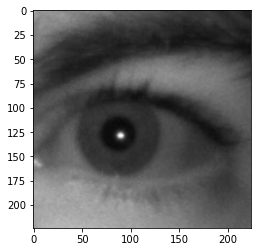

In [15]:
predictor('dataset/test_dataset/open_eyes/s0014_08361_0_0_1_1_0_02.png')

[[0.99934804]]


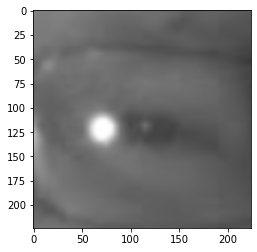

In [17]:
predictor('dataset/test_dataset/open_eyes/s0022_00356_0_1_1_2_1_01.png')

#### 2. Closed Eyes

[[1.5737765e-05]]


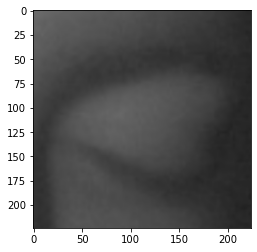

In [16]:
predictor('dataset/test_dataset/closed_eyes/s0014_00860_0_0_0_0_0_01.png')

[[6.6007764e-05]]


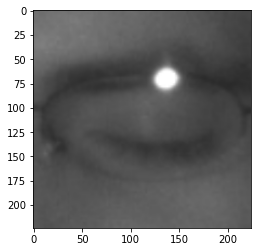

In [18]:
predictor('dataset/test_dataset/closed_eyes/s0012_01951_0_1_0_2_0_01.png')

### Pattern Recognized:
    1. For images with open eyes, prediction value is > 0.9
    2. For images with closed eyes, the prediction value is close to < 0.1

# **Live Video Feed Implementation**

In [8]:
path = "haarcascade_frontalface_default.xml"

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1) #the argument in VideoCapture() refers to the video capture device number configured

while True:
    ret, frame = cap.read()
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    for(x, y, w, h) in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        eyes_2 = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes_2) == 0:
            print("Eyes not Detected")
        else:
            for(ex, ey, ew, eh) in eyes_2:
                eyes_roi = roi_color[ey:ey+eh, ex:ex+ew]
                
    final_roi_img = cv2.resize(eyes_roi, (224, 224))
    final_roi_img = np.expand_dims(final_roi_img, axis = 0)
    # adding another dimension as the model requires 4 dimensions, for eg (img.shape -> (1, 224, 224, 3))
    final_roi_img = final_roi_img/255.0        #normalising
    
    predictions = new_model.predict(final_roi_img)
    if(predictions > 0.9):
        status = "Eyes Open"
    else:
        status = "Eyes Closed"
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    print(face_cascade.empty())
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    # drawing rectangle around eyes

    for(x, y, w, h) in eyes:
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    #Inserting text on video
    cv2.putText(
        frame,
        status,    #text to be written
        (50,50),   #offset
        font,
        3,         #font size
        (0,0,255), #font color
        2,
        cv2.LINE_4
    )
    cv2.imshow("Drowsiness Detection", frame)
    
    #exiting the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()    

False
False
False
False
False


### Output from the Video Feed

1. Open Eyes
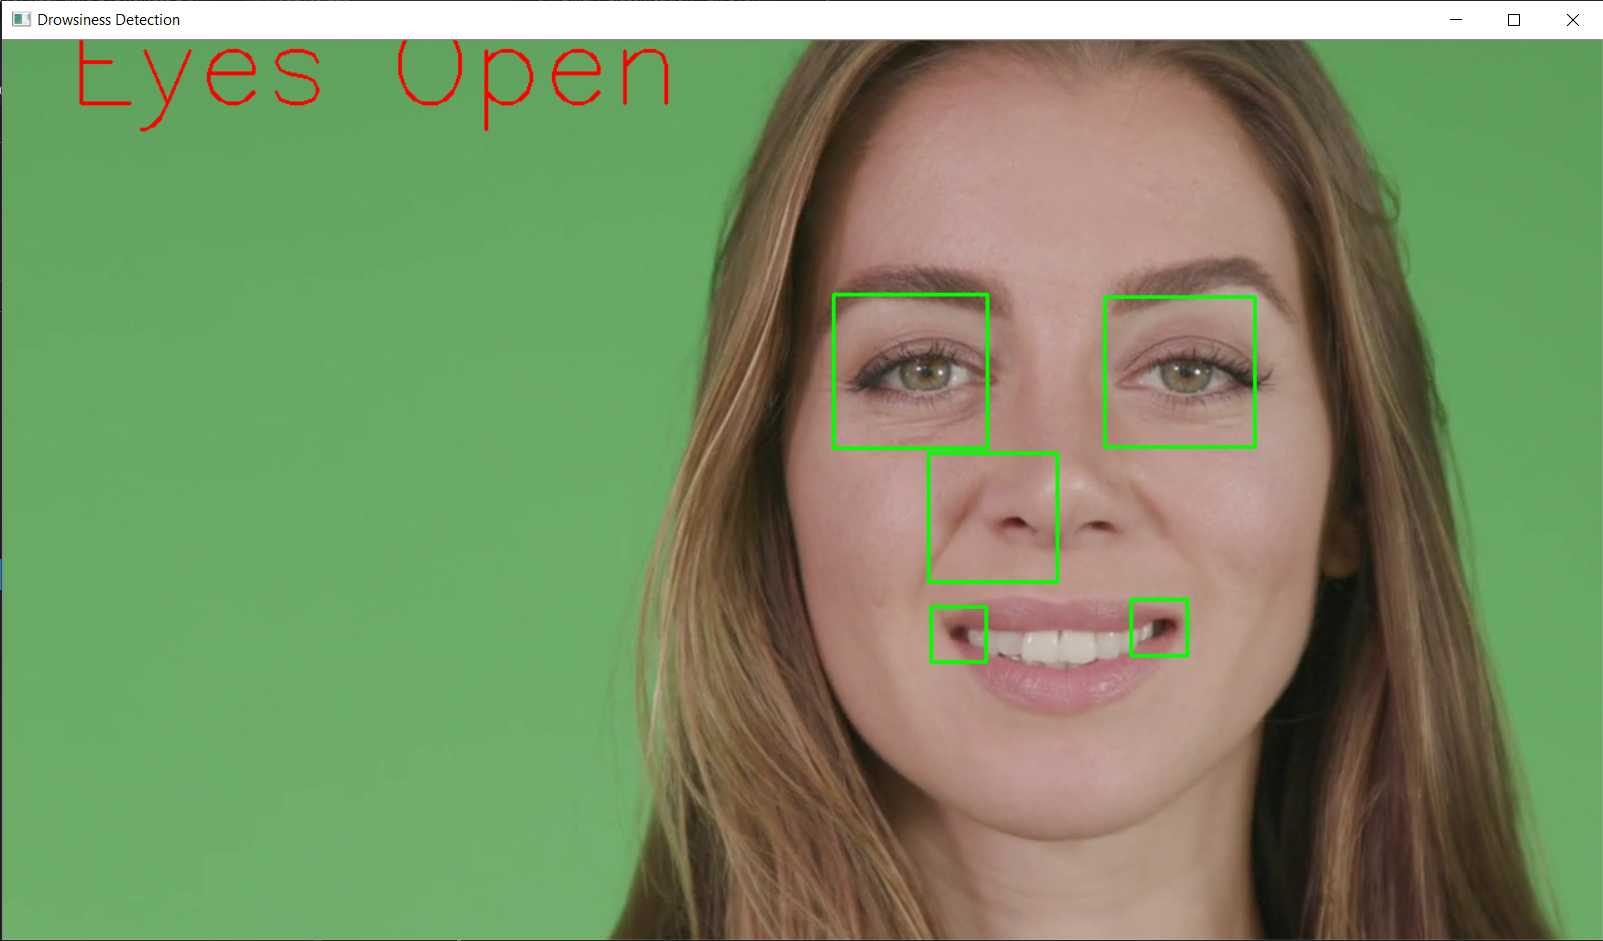

2. Closed Eyes
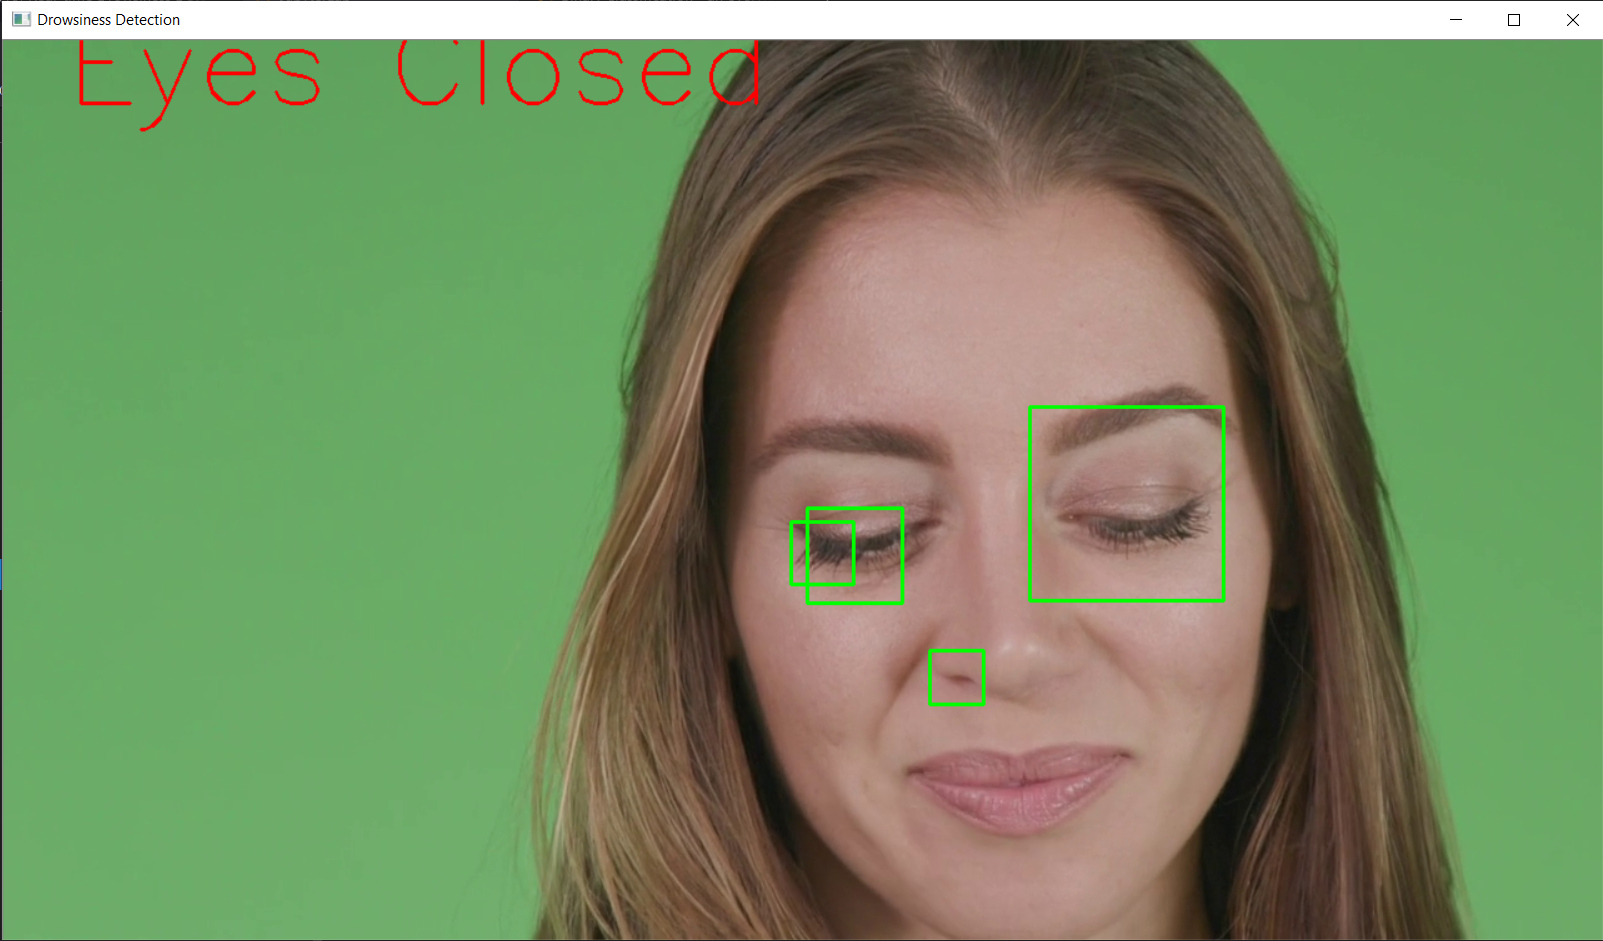


Video Source: [pexels.com](https://www.pexels.com/video/close-up-of-a-woman-showing-different-facial-expressions-3063839/)